<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [BHPD2] - Regression with a Dense Network (DNN) - Advanced code
  <!-- DESC -->  A more advanced implementation of the precedent example
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide these information :

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('BHPD2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0
Notebook id          : BHPD2
Run time             : Thursday 14 January 2021, 08:11:30
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [2]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.2, seed=113)

### 2.2 - Option 2 : From a csv file
More fun !

In [3]:
data = pd.read_csv(f'{datasets_dir}/BHPD/origine/BostonHousing.csv', header=0)

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Missing Data :  0   Shape is :  (506, 14)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be input data and y the expected output

In [4]:
# ---- Split => train, test
#
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [5]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.62,12.34,11.04,0.06,0.56,6.32,69.45,3.77,9.72,409.79,18.47,355.96,12.61
std,8.57,24.67,6.91,0.24,0.12,0.71,27.79,2.14,8.83,169.10,2.21,93.17,7.14
min,0.01,0.00,0.46,0.00,0.39,3.86,6.00,1.13,1.00,187.00,12.60,0.32,1.73
25%,0.07,0.00,4.93,0.00,0.45,5.93,45.18,2.10,4.00,277.00,17.40,375.29,6.92
50%,0.25,0.00,9.69,0.00,0.54,6.24,79.20,3.10,5.00,336.00,19.10,391.47,11.49
75%,3.82,19.50,18.10,0.00,0.63,6.63,94.10,5.12,24.00,666.00,20.20,396.29,16.57
max,88.98,100.00,27.74,1.00,0.87,8.72,100.00,12.13,24.00,711.00,22.00,396.90,37.97


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.42,-0.50,-1.53,-0.25,-1.46,-3.47,-2.28,-1.24,-0.99,-1.32,-2.65,-3.82,-1.52
25%,-0.41,-0.50,-0.88,-0.25,-0.88,-0.54,-0.87,-0.78,-0.65,-0.79,-0.48,0.21,-0.80
50%,-0.39,-0.50,-0.20,-0.25,-0.18,-0.10,0.35,-0.32,-0.53,-0.44,0.28,0.38,-0.16
75%,0.02,0.29,1.02,-0.25,0.65,0.44,0.89,0.63,1.62,1.52,0.78,0.43,0.55
max,9.96,3.55,2.42,3.98,2.71,3.40,1.10,3.90,1.62,1.78,1.59,0.44,3.55


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [6]:
  def get_model_v1(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(1, name='Output'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

## 5 - Train the model
### 5.1 - Get it

In [7]:
model=get_model_v1( (13,) )

model.summary()
# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [8]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3 - Train it

In [9]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100


 1/36 [..............................] - ETA: 0s - loss: 389.7831 - mae: 18.9112 - mse: 389.7831

36/36 [==============================] - 0s 5ms/step - loss: 479.8606 - mae: 19.7624 - mse: 479.8606 - val_loss: 313.9207 - val_mae: 15.7939 - val_mse: 313.9207


Epoch 2/100
 1/36 [..............................] - ETA: 0s - loss: 433.2456 - mae: 17.4410 - mse: 433.2456

36/36 [==============================] - 0s 2ms/step - loss: 251.0171 - mae: 13.3376 - mse: 251.0171 - val_loss: 115.0622 - val_mae: 8.7007 - val_mse: 115.0622


Epoch 3/100
 1/36 [..............................] - ETA: 0s - loss: 74.5882 - mae: 7.4639 - mse: 74.5882

36/36 [==============================] - 0s 2ms/step - loss: 97.0846 - mae: 7.5000 - mse: 97.0846 - val_loss: 48.7695 - val_mae: 5.3898 - val_mse: 48.7695


Epoch 4/100
 1/36 [..............................] - ETA: 0s - loss: 155.7348 - mae: 9.1847 - mse: 155.7348

36/36 [==============================] - 0s 2ms/step - loss: 54.7528 - mae: 5.4036 - mse: 54.7528 - val_loss: 29.9846 - val_mae: 4.1754 - val_mse: 29.9846


Epoch 5/100
 1/36 [..............................] - ETA: 0s - loss: 40.2903 - mae: 5.0659 - mse: 40.2903

36/36 [==============================] - 0s 2ms/step - loss: 35.3013 - mae: 4.2298 - mse: 35.3013 - val_loss: 21.5246 - val_mae: 3.5020 - val_mse: 21.5246


Epoch 6/100
 1/36 [..............................] - ETA: 0s - loss: 20.8753 - mae: 3.7356 - mse: 20.8753

36/36 [==============================] - 0s 2ms/step - loss: 26.6657 - mae: 3.6815 - mse: 26.6657 - val_loss: 18.1473 - val_mae: 3.1323 - val_mse: 18.1473


Epoch 7/100
 1/36 [..............................] - ETA: 0s - loss: 5.2121 - mae: 2.0190 - mse: 5.2121

36/36 [==============================] - 0s 2ms/step - loss: 22.8042 - mae: 3.3342 - mse: 22.8042 - val_loss: 16.4765 - val_mae: 2.9579 - val_mse: 16.4765


Epoch 8/100
 1/36 [..............................] - ETA: 0s - loss: 8.9479 - mae: 2.4739 - mse: 8.9479

36/36 [==============================] - 0s 2ms/step - loss: 19.7496 - mae: 3.1010 - mse: 19.7496 - val_loss: 15.8385 - val_mae: 2.8592 - val_mse: 15.8385


Epoch 9/100
 1/36 [..............................] - ETA: 0s - loss: 9.2032 - mae: 2.8548 - mse: 9.2032

36/36 [==============================] - 0s 2ms/step - loss: 17.5905 - mae: 2.9337 - mse: 17.5905 - val_loss: 16.9321 - val_mae: 2.9213 - val_mse: 16.9321


Epoch 10/100
 1/36 [..............................] - ETA: 0s - loss: 18.1565 - mae: 3.8637 - mse: 18.1565

36/36 [==============================] - 0s 2ms/step - loss: 16.4101 - mae: 2.8449 - mse: 16.4101 - val_loss: 15.1185 - val_mae: 2.7206 - val_mse: 15.1185


Epoch 11/100
 1/36 [..............................] - ETA: 0s - loss: 5.8267 - mae: 1.9830 - mse: 5.8267

36/36 [==============================] - 0s 2ms/step - loss: 15.2091 - mae: 2.7126 - mse: 15.2091 - val_loss: 14.4734 - val_mae: 2.5941 - val_mse: 14.4734


Epoch 12/100
 1/36 [..............................] - ETA: 0s - loss: 6.2744 - mae: 2.2298 - mse: 6.2744

36/36 [==============================] - 0s 2ms/step - loss: 14.4579 - mae: 2.6564 - mse: 14.4579 - val_loss: 14.6208 - val_mae: 2.5923 - val_mse: 14.6208


Epoch 13/100
 1/36 [..............................] - ETA: 0s - loss: 7.3490 - mae: 1.9336 - mse: 7.3490

36/36 [==============================] - 0s 2ms/step - loss: 13.7957 - mae: 2.6243 - mse: 13.7957 - val_loss: 14.1156 - val_mae: 2.5347 - val_mse: 14.1156


Epoch 14/100
 1/36 [..............................] - ETA: 0s - loss: 7.1917 - mae: 2.2493 - mse: 7.1917

36/36 [==============================] - 0s 2ms/step - loss: 12.9634 - mae: 2.5102 - mse: 12.9634 - val_loss: 14.7697 - val_mae: 2.6119 - val_mse: 14.7697


Epoch 15/100
 1/36 [..............................] - ETA: 0s - loss: 7.7120 - mae: 2.1875 - mse: 7.7120

36/36 [==============================] - 0s 2ms/step - loss: 12.4422 - mae: 2.4581 - mse: 12.4422 - val_loss: 14.6517 - val_mae: 2.5601 - val_mse: 14.6517


Epoch 16/100
 1/36 [..............................] - ETA: 0s - loss: 10.8231 - mae: 2.9008 - mse: 10.8231

36/36 [==============================] - 0s 2ms/step - loss: 12.2225 - mae: 2.4426 - mse: 12.2225 - val_loss: 14.7885 - val_mae: 2.5623 - val_mse: 14.7885


Epoch 17/100
 1/36 [..............................] - ETA: 0s - loss: 27.0570 - mae: 3.0176 - mse: 27.0570

36/36 [==============================] - 0s 2ms/step - loss: 11.8573 - mae: 2.3869 - mse: 11.8573 - val_loss: 14.4856 - val_mae: 2.4999 - val_mse: 14.4856


Epoch 18/100
 1/36 [..............................] - ETA: 0s - loss: 3.2214 - mae: 1.5709 - mse: 3.2214

36/36 [==============================] - 0s 2ms/step - loss: 11.2766 - mae: 2.3107 - mse: 11.2766 - val_loss: 16.2192 - val_mae: 2.6771 - val_mse: 16.2192


Epoch 19/100
 1/36 [..............................] - ETA: 0s - loss: 53.4781 - mae: 4.6768 - mse: 53.4781

36/36 [==============================] - 0s 2ms/step - loss: 10.8904 - mae: 2.3221 - mse: 10.8904 - val_loss: 14.7529 - val_mae: 2.5405 - val_mse: 14.7529


Epoch 20/100
 1/36 [..............................] - ETA: 0s - loss: 5.6295 - mae: 2.1028 - mse: 5.6295

36/36 [==============================] - 0s 2ms/step - loss: 10.7788 - mae: 2.2706 - mse: 10.7788 - val_loss: 14.5959 - val_mae: 2.4926 - val_mse: 14.5959


Epoch 21/100
 1/36 [..............................] - ETA: 0s - loss: 11.0794 - mae: 2.7306 - mse: 11.0794

36/36 [==============================] - 0s 2ms/step - loss: 10.4161 - mae: 2.2696 - mse: 10.4161 - val_loss: 14.7912 - val_mae: 2.5766 - val_mse: 14.7912


Epoch 22/100
 1/36 [..............................] - ETA: 0s - loss: 9.3141 - mae: 2.6085 - mse: 9.3141

36/36 [==============================] - 0s 2ms/step - loss: 10.3055 - mae: 2.2356 - mse: 10.3055 - val_loss: 14.8611 - val_mae: 2.5488 - val_mse: 14.8611


Epoch 23/100
 1/36 [..............................] - ETA: 0s - loss: 3.9928 - mae: 1.6222 - mse: 3.9928

36/36 [==============================] - 0s 2ms/step - loss: 10.2244 - mae: 2.2373 - mse: 10.2244 - val_loss: 14.9809 - val_mae: 2.5411 - val_mse: 14.9809


Epoch 24/100
 1/36 [..............................] - ETA: 0s - loss: 18.7919 - mae: 3.8043 - mse: 18.7919

36/36 [==============================] - 0s 2ms/step - loss: 10.2347 - mae: 2.1896 - mse: 10.2347 - val_loss: 14.1357 - val_mae: 2.4829 - val_mse: 14.1357


Epoch 25/100
 1/36 [..............................] - ETA: 0s - loss: 9.7434 - mae: 2.4112 - mse: 9.7434

36/36 [==============================] - 0s 2ms/step - loss: 9.9127 - mae: 2.2199 - mse: 9.9127 - val_loss: 14.9639 - val_mae: 2.5534 - val_mse: 14.9639


Epoch 26/100
 1/36 [..............................] - ETA: 0s - loss: 4.2105 - mae: 1.5460 - mse: 4.2105

36/36 [==============================] - 0s 2ms/step - loss: 9.7643 - mae: 2.1699 - mse: 9.7643 - val_loss: 15.1165 - val_mae: 2.6070 - val_mse: 15.1165


Epoch 27/100
 1/36 [..............................] - ETA: 0s - loss: 13.3942 - mae: 2.9616 - mse: 13.3942

36/36 [==============================] - 0s 2ms/step - loss: 9.7912 - mae: 2.1629 - mse: 9.7912 - val_loss: 14.3873 - val_mae: 2.4969 - val_mse: 14.3873


Epoch 28/100
 1/36 [..............................] - ETA: 0s - loss: 5.3006 - mae: 1.8108 - mse: 5.3006

36/36 [==============================] - 0s 2ms/step - loss: 9.3235 - mae: 2.0974 - mse: 9.3235 - val_loss: 14.1615 - val_mae: 2.4547 - val_mse: 14.1615


Epoch 29/100
 1/36 [..............................] - ETA: 0s - loss: 6.5976 - mae: 2.0674 - mse: 6.5976

36/36 [==============================] - 0s 2ms/step - loss: 9.3655 - mae: 2.1701 - mse: 9.3655 - val_loss: 13.7438 - val_mae: 2.4387 - val_mse: 13.7438


Epoch 30/100
 1/36 [..............................] - ETA: 0s - loss: 9.5997 - mae: 2.5383 - mse: 9.5997

36/36 [==============================] - 0s 2ms/step - loss: 9.2931 - mae: 2.1114 - mse: 9.2931 - val_loss: 14.9816 - val_mae: 2.4900 - val_mse: 14.9816


Epoch 31/100
 1/36 [..............................] - ETA: 0s - loss: 6.8495 - mae: 1.8740 - mse: 6.8495

36/36 [==============================] - 0s 3ms/step - loss: 9.2603 - mae: 2.1166 - mse: 9.2603 - val_loss: 14.0484 - val_mae: 2.4778 - val_mse: 14.0484


Epoch 32/100


 1/36 [..............................] - ETA: 0s - loss: 5.3201 - mae: 1.8011 - mse: 5.3201

36/36 [==============================] - 0s 2ms/step - loss: 8.9376 - mae: 2.0842 - mse: 8.9376 - val_loss: 14.9942 - val_mae: 2.5042 - val_mse: 14.9942


Epoch 33/100
 1/36 [..............................] - ETA: 0s - loss: 8.2969 - mae: 2.1881 - mse: 8.2969

36/36 [==============================] - 0s 2ms/step - loss: 8.9194 - mae: 2.1055 - mse: 8.9194 - val_loss: 14.8121 - val_mae: 2.5208 - val_mse: 14.8121


Epoch 34/100
 1/36 [..............................] - ETA: 0s - loss: 5.3883 - mae: 1.6524 - mse: 5.3883

36/36 [==============================] - 0s 2ms/step - loss: 8.8447 - mae: 2.0719 - mse: 8.8447 - val_loss: 14.3170 - val_mae: 2.4864 - val_mse: 14.3170


Epoch 35/100
 1/36 [..............................] - ETA: 0s - loss: 43.8930 - mae: 3.2587 - mse: 43.8930

36/36 [==============================] - 0s 2ms/step - loss: 8.6136 - mae: 2.0538 - mse: 8.6136 - val_loss: 14.6798 - val_mae: 2.4802 - val_mse: 14.6798


Epoch 36/100
 1/36 [..............................] - ETA: 0s - loss: 2.5058 - mae: 1.1864 - mse: 2.5058

36/36 [==============================] - 0s 2ms/step - loss: 8.7849 - mae: 2.0455 - mse: 8.7849 - val_loss: 13.8648 - val_mae: 2.4560 - val_mse: 13.8648


Epoch 37/100
 1/36 [..............................] - ETA: 0s - loss: 7.9070 - mae: 2.1361 - mse: 7.9070

36/36 [==============================] - 0s 2ms/step - loss: 8.6908 - mae: 2.0650 - mse: 8.6908 - val_loss: 14.2627 - val_mae: 2.4784 - val_mse: 14.2627


Epoch 38/100
 1/36 [..............................] - ETA: 0s - loss: 6.9295 - mae: 2.1939 - mse: 6.9295

36/36 [==============================] - 0s 2ms/step - loss: 8.3519 - mae: 2.0229 - mse: 8.3519 - val_loss: 14.1649 - val_mae: 2.4617 - val_mse: 14.1649


Epoch 39/100
 1/36 [..............................] - ETA: 0s - loss: 3.1359 - mae: 1.4777 - mse: 3.1359

36/36 [==============================] - 0s 2ms/step - loss: 8.3464 - mae: 2.0540 - mse: 8.3464 - val_loss: 13.2801 - val_mae: 2.4016 - val_mse: 13.2801


Epoch 40/100
 1/36 [..............................] - ETA: 0s - loss: 4.0241 - mae: 1.5442 - mse: 4.0241

36/36 [==============================] - 0s 2ms/step - loss: 8.1010 - mae: 1.9930 - mse: 8.1010 - val_loss: 13.5650 - val_mae: 2.4058 - val_mse: 13.5650


Epoch 41/100
 1/36 [..............................] - ETA: 0s - loss: 11.5849 - mae: 2.2403 - mse: 11.5849

36/36 [==============================] - 0s 2ms/step - loss: 8.0642 - mae: 1.9751 - mse: 8.0642 - val_loss: 15.4452 - val_mae: 2.5221 - val_mse: 15.4452


Epoch 42/100
 1/36 [..............................] - ETA: 0s - loss: 7.4993 - mae: 2.3373 - mse: 7.4993

36/36 [==============================] - 0s 2ms/step - loss: 8.0004 - mae: 1.9871 - mse: 8.0004 - val_loss: 13.8006 - val_mae: 2.4717 - val_mse: 13.8006


Epoch 43/100
 1/36 [..............................] - ETA: 0s - loss: 9.1996 - mae: 1.9518 - mse: 9.1996

36/36 [==============================] - 0s 2ms/step - loss: 8.0023 - mae: 1.9510 - mse: 8.0023 - val_loss: 13.7937 - val_mae: 2.4129 - val_mse: 13.7937


Epoch 44/100
 1/36 [..............................] - ETA: 0s - loss: 12.7615 - mae: 2.7751 - mse: 12.7615

36/36 [==============================] - 0s 2ms/step - loss: 7.8025 - mae: 1.9665 - mse: 7.8025 - val_loss: 14.2702 - val_mae: 2.5141 - val_mse: 14.2702


Epoch 45/100
 1/36 [..............................] - ETA: 0s - loss: 9.2198 - mae: 2.2451 - mse: 9.2198

36/36 [==============================] - 0s 2ms/step - loss: 7.7570 - mae: 1.9942 - mse: 7.7570 - val_loss: 13.6718 - val_mae: 2.4283 - val_mse: 13.6718


Epoch 46/100
 1/36 [..............................] - ETA: 0s - loss: 12.3138 - mae: 2.8130 - mse: 12.3138

36/36 [==============================] - 0s 2ms/step - loss: 7.6489 - mae: 1.9492 - mse: 7.6489 - val_loss: 13.4847 - val_mae: 2.4089 - val_mse: 13.4847


Epoch 47/100
 1/36 [..............................] - ETA: 0s - loss: 4.0593 - mae: 1.6419 - mse: 4.0593

36/36 [==============================] - 0s 2ms/step - loss: 7.6494 - mae: 1.9502 - mse: 7.6494 - val_loss: 14.3631 - val_mae: 2.4726 - val_mse: 14.3631


Epoch 48/100
 1/36 [..............................] - ETA: 0s - loss: 1.2665 - mae: 0.8139 - mse: 1.2665

36/36 [==============================] - 0s 2ms/step - loss: 7.6113 - mae: 1.9259 - mse: 7.6113 - val_loss: 14.7889 - val_mae: 2.4596 - val_mse: 14.7889


Epoch 49/100
 1/36 [..............................] - ETA: 0s - loss: 4.0618 - mae: 1.7699 - mse: 4.0618

36/36 [==============================] - 0s 2ms/step - loss: 7.6278 - mae: 1.9507 - mse: 7.6278 - val_loss: 15.5162 - val_mae: 2.5617 - val_mse: 15.5162


Epoch 50/100
 1/36 [..............................] - ETA: 0s - loss: 5.1634 - mae: 1.8709 - mse: 5.1634

36/36 [==============================] - 0s 2ms/step - loss: 7.3041 - mae: 1.9047 - mse: 7.3041 - val_loss: 13.3008 - val_mae: 2.4135 - val_mse: 13.3008


Epoch 51/100
 1/36 [..............................] - ETA: 0s - loss: 3.6307 - mae: 1.4810 - mse: 3.6307

36/36 [==============================] - 0s 2ms/step - loss: 7.2821 - mae: 1.9214 - mse: 7.2821 - val_loss: 13.3205 - val_mae: 2.4189 - val_mse: 13.3205


Epoch 52/100
 1/36 [..............................] - ETA: 0s - loss: 13.3746 - mae: 2.3897 - mse: 13.3746

36/36 [==============================] - 0s 2ms/step - loss: 7.3565 - mae: 1.8909 - mse: 7.3565 - val_loss: 13.3063 - val_mae: 2.3615 - val_mse: 13.3063


Epoch 53/100
 1/36 [..............................] - ETA: 0s - loss: 16.4461 - mae: 2.9820 - mse: 16.4461

36/36 [==============================] - 0s 2ms/step - loss: 7.2399 - mae: 1.8732 - mse: 7.2399 - val_loss: 13.0869 - val_mae: 2.3626 - val_mse: 13.0869


Epoch 54/100
 1/36 [..............................] - ETA: 0s - loss: 5.4357 - mae: 1.9095 - mse: 5.4357

36/36 [==============================] - 0s 2ms/step - loss: 7.3204 - mae: 1.8823 - mse: 7.3204 - val_loss: 13.6383 - val_mae: 2.3804 - val_mse: 13.6383


Epoch 55/100
 1/36 [..............................] - ETA: 0s - loss: 9.5260 - mae: 2.6376 - mse: 9.5260

36/36 [==============================] - 0s 2ms/step - loss: 6.9565 - mae: 1.8496 - mse: 6.9565 - val_loss: 14.2109 - val_mae: 2.4282 - val_mse: 14.2109


Epoch 56/100
 1/36 [..............................] - ETA: 0s - loss: 5.3659 - mae: 1.8715 - mse: 5.3659

36/36 [==============================] - 0s 2ms/step - loss: 7.0620 - mae: 1.8954 - mse: 7.0620 - val_loss: 13.3942 - val_mae: 2.3656 - val_mse: 13.3942


Epoch 57/100
 1/36 [..............................] - ETA: 0s - loss: 1.4456 - mae: 1.0507 - mse: 1.4456

36/36 [==============================] - 0s 2ms/step - loss: 7.0092 - mae: 1.8819 - mse: 7.0092 - val_loss: 13.4036 - val_mae: 2.3867 - val_mse: 13.4036


Epoch 58/100
 1/36 [..............................] - ETA: 0s - loss: 6.4874 - mae: 2.1595 - mse: 6.4874

36/36 [==============================] - 0s 2ms/step - loss: 6.9920 - mae: 1.8659 - mse: 6.9920 - val_loss: 13.8693 - val_mae: 2.4016 - val_mse: 13.8693


Epoch 59/100
 1/36 [..............................] - ETA: 0s - loss: 2.6567 - mae: 1.3746 - mse: 2.6567

36/36 [==============================] - 0s 2ms/step - loss: 6.9226 - mae: 1.8695 - mse: 6.9226 - val_loss: 13.8495 - val_mae: 2.4325 - val_mse: 13.8495


Epoch 60/100
 1/36 [..............................] - ETA: 0s - loss: 11.7619 - mae: 2.2614 - mse: 11.7619

36/36 [==============================] - 0s 2ms/step - loss: 6.8162 - mae: 1.8100 - mse: 6.8162 - val_loss: 15.4320 - val_mae: 2.5449 - val_mse: 15.4320


Epoch 61/100
 1/36 [..............................] - ETA: 0s - loss: 8.1087 - mae: 2.3767 - mse: 8.1087

36/36 [==============================] - 0s 2ms/step - loss: 6.9133 - mae: 1.8762 - mse: 6.9133 - val_loss: 12.9091 - val_mae: 2.3326 - val_mse: 12.9091


Epoch 62/100
 1/36 [..............................] - ETA: 0s - loss: 3.9485 - mae: 1.4542 - mse: 3.9485

36/36 [==============================] - 0s 2ms/step - loss: 6.7509 - mae: 1.8198 - mse: 6.7509 - val_loss: 13.1486 - val_mae: 2.3938 - val_mse: 13.1486


Epoch 63/100
 1/36 [..............................] - ETA: 0s - loss: 8.7804 - mae: 2.3251 - mse: 8.7804

36/36 [==============================] - 0s 2ms/step - loss: 6.4485 - mae: 1.7494 - mse: 6.4485 - val_loss: 14.8389 - val_mae: 2.5481 - val_mse: 14.8389


Epoch 64/100
 1/36 [..............................] - ETA: 0s - loss: 4.9892 - mae: 1.6083 - mse: 4.9892

36/36 [==============================] - 0s 2ms/step - loss: 6.6330 - mae: 1.7830 - mse: 6.6330 - val_loss: 13.3076 - val_mae: 2.3590 - val_mse: 13.3076


Epoch 65/100
 1/36 [..............................] - ETA: 0s - loss: 1.0009 - mae: 0.9182 - mse: 1.0009

36/36 [==============================] - 0s 2ms/step - loss: 6.4051 - mae: 1.8167 - mse: 6.4051 - val_loss: 13.1992 - val_mae: 2.3794 - val_mse: 13.1992


Epoch 66/100
 1/36 [..............................] - ETA: 0s - loss: 1.8588 - mae: 0.9972 - mse: 1.8588

36/36 [==============================] - 0s 2ms/step - loss: 6.4886 - mae: 1.7793 - mse: 6.4886 - val_loss: 13.0932 - val_mae: 2.3837 - val_mse: 13.0932


Epoch 67/100
 1/36 [..............................] - ETA: 0s - loss: 10.6858 - mae: 2.4324 - mse: 10.6858

36/36 [==============================] - 0s 2ms/step - loss: 6.2730 - mae: 1.7868 - mse: 6.2730 - val_loss: 13.0315 - val_mae: 2.3573 - val_mse: 13.0315


Epoch 68/100
 1/36 [..............................] - ETA: 0s - loss: 1.6576 - mae: 1.1708 - mse: 1.6576

36/36 [==============================] - 0s 2ms/step - loss: 6.3058 - mae: 1.7874 - mse: 6.3058 - val_loss: 13.9050 - val_mae: 2.5099 - val_mse: 13.9050


Epoch 69/100
 1/36 [..............................] - ETA: 0s - loss: 6.3165 - mae: 1.8470 - mse: 6.3165

36/36 [==============================] - 0s 2ms/step - loss: 6.3884 - mae: 1.7905 - mse: 6.3884 - val_loss: 13.3257 - val_mae: 2.3857 - val_mse: 13.3257


Epoch 70/100
 1/36 [..............................] - ETA: 0s - loss: 4.2936 - mae: 1.5829 - mse: 4.2936

36/36 [==============================] - 0s 2ms/step - loss: 6.2250 - mae: 1.7537 - mse: 6.2250 - val_loss: 13.8636 - val_mae: 2.3860 - val_mse: 13.8636


Epoch 71/100
 1/36 [..............................] - ETA: 0s - loss: 9.3276 - mae: 2.4125 - mse: 9.3276

36/36 [==============================] - 0s 2ms/step - loss: 6.2631 - mae: 1.7455 - mse: 6.2631 - val_loss: 14.0767 - val_mae: 2.4031 - val_mse: 14.0767


Epoch 72/100
 1/36 [..............................] - ETA: 0s - loss: 4.0660 - mae: 1.6098 - mse: 4.0660

36/36 [==============================] - 0s 2ms/step - loss: 6.2287 - mae: 1.7631 - mse: 6.2287 - val_loss: 13.2292 - val_mae: 2.3698 - val_mse: 13.2292


Epoch 73/100
 1/36 [..............................] - ETA: 0s - loss: 6.0104 - mae: 2.1212 - mse: 6.0104

36/36 [==============================] - 0s 2ms/step - loss: 5.8985 - mae: 1.7454 - mse: 5.8985 - val_loss: 12.8910 - val_mae: 2.3427 - val_mse: 12.8910


Epoch 74/100
 1/36 [..............................] - ETA: 0s - loss: 3.1137 - mae: 1.5237 - mse: 3.1137

36/36 [==============================] - 0s 2ms/step - loss: 6.2723 - mae: 1.7694 - mse: 6.2723 - val_loss: 12.5268 - val_mae: 2.3041 - val_mse: 12.5268


Epoch 75/100
 1/36 [..............................] - ETA: 0s - loss: 9.1033 - mae: 2.2568 - mse: 9.1033

36/36 [==============================] - 0s 2ms/step - loss: 5.8947 - mae: 1.7714 - mse: 5.8947 - val_loss: 12.7933 - val_mae: 2.2887 - val_mse: 12.7933


Epoch 76/100
 1/36 [..............................] - ETA: 0s - loss: 5.1906 - mae: 1.5643 - mse: 5.1906

36/36 [==============================] - 0s 2ms/step - loss: 5.8951 - mae: 1.6732 - mse: 5.8951 - val_loss: 15.5230 - val_mae: 2.5715 - val_mse: 15.5230


Epoch 77/100
 1/36 [..............................] - ETA: 0s - loss: 4.2202 - mae: 1.7130 - mse: 4.2202

36/36 [==============================] - 0s 2ms/step - loss: 5.9246 - mae: 1.7435 - mse: 5.9246 - val_loss: 13.4371 - val_mae: 2.4378 - val_mse: 13.4371


Epoch 78/100
 1/36 [..............................] - ETA: 0s - loss: 15.0750 - mae: 2.4584 - mse: 15.0750

36/36 [==============================] - 0s 2ms/step - loss: 5.7637 - mae: 1.6898 - mse: 5.7637 - val_loss: 12.9896 - val_mae: 2.3241 - val_mse: 12.9896


Epoch 79/100
 1/36 [..............................] - ETA: 0s - loss: 5.7574 - mae: 1.9001 - mse: 5.7574

36/36 [==============================] - 0s 2ms/step - loss: 5.6239 - mae: 1.6565 - mse: 5.6239 - val_loss: 12.9841 - val_mae: 2.4193 - val_mse: 12.9841


Epoch 80/100
 1/36 [..............................] - ETA: 0s - loss: 3.9726 - mae: 1.7022 - mse: 3.9726

36/36 [==============================] - 0s 2ms/step - loss: 5.6628 - mae: 1.7008 - mse: 5.6628 - val_loss: 14.2899 - val_mae: 2.5081 - val_mse: 14.2899


Epoch 81/100
 1/36 [..............................] - ETA: 0s - loss: 4.9900 - mae: 1.9765 - mse: 4.9900

36/36 [==============================] - 0s 2ms/step - loss: 5.6927 - mae: 1.6930 - mse: 5.6927 - val_loss: 12.6935 - val_mae: 2.3240 - val_mse: 12.6935


Epoch 82/100
 1/36 [..............................] - ETA: 0s - loss: 6.9577 - mae: 2.0217 - mse: 6.9577

36/36 [==============================] - 0s 2ms/step - loss: 5.4944 - mae: 1.7029 - mse: 5.4944 - val_loss: 13.6903 - val_mae: 2.3776 - val_mse: 13.6903


Epoch 83/100
 1/36 [..............................] - ETA: 0s - loss: 3.2078 - mae: 1.5954 - mse: 3.2078

36/36 [==============================] - 0s 2ms/step - loss: 5.6522 - mae: 1.7010 - mse: 5.6522 - val_loss: 12.7517 - val_mae: 2.3456 - val_mse: 12.7517


Epoch 84/100
 1/36 [..............................] - ETA: 0s - loss: 4.7529 - mae: 1.9461 - mse: 4.7529

36/36 [==============================] - 0s 2ms/step - loss: 5.5479 - mae: 1.6726 - mse: 5.5479 - val_loss: 12.3647 - val_mae: 2.3047 - val_mse: 12.3647


Epoch 85/100
 1/36 [..............................] - ETA: 0s - loss: 1.5596 - mae: 0.8798 - mse: 1.5596

36/36 [==============================] - 0s 2ms/step - loss: 5.4444 - mae: 1.6182 - mse: 5.4444 - val_loss: 12.5509 - val_mae: 2.3111 - val_mse: 12.5509


Epoch 86/100
 1/36 [..............................] - ETA: 0s - loss: 7.4941 - mae: 2.1528 - mse: 7.4941

36/36 [==============================] - 0s 2ms/step - loss: 5.4652 - mae: 1.6338 - mse: 5.4652 - val_loss: 12.5566 - val_mae: 2.3542 - val_mse: 12.5566


Epoch 87/100
 1/36 [..............................] - ETA: 0s - loss: 3.4916 - mae: 1.5555 - mse: 3.4916

36/36 [==============================] - 0s 2ms/step - loss: 5.5666 - mae: 1.6390 - mse: 5.5666 - val_loss: 12.4106 - val_mae: 2.3009 - val_mse: 12.4106


Epoch 88/100
 1/36 [..............................] - ETA: 0s - loss: 17.3554 - mae: 2.8161 - mse: 17.3554

36/36 [==============================] - 0s 2ms/step - loss: 5.2077 - mae: 1.6400 - mse: 5.2077 - val_loss: 13.3929 - val_mae: 2.3591 - val_mse: 13.3929


Epoch 89/100
 1/36 [..............................] - ETA: 0s - loss: 1.2050 - mae: 0.8373 - mse: 1.2050

36/36 [==============================] - 0s 2ms/step - loss: 5.3255 - mae: 1.6316 - mse: 5.3255 - val_loss: 13.3948 - val_mae: 2.3415 - val_mse: 13.3948


Epoch 90/100
 1/36 [..............................] - ETA: 0s - loss: 4.0811 - mae: 1.6029 - mse: 4.0811

36/36 [==============================] - 0s 2ms/step - loss: 5.2528 - mae: 1.5911 - mse: 5.2528 - val_loss: 14.7952 - val_mae: 2.4915 - val_mse: 14.7952


Epoch 91/100
 1/36 [..............................] - ETA: 0s - loss: 8.1721 - mae: 2.1004 - mse: 8.1721

36/36 [==============================] - 0s 2ms/step - loss: 5.2857 - mae: 1.6431 - mse: 5.2857 - val_loss: 13.3228 - val_mae: 2.4061 - val_mse: 13.3228


Epoch 92/100
 1/36 [..............................] - ETA: 0s - loss: 6.6123 - mae: 2.0193 - mse: 6.6123

36/36 [==============================] - 0s 2ms/step - loss: 5.3257 - mae: 1.6181 - mse: 5.3257 - val_loss: 12.9694 - val_mae: 2.3735 - val_mse: 12.9694


Epoch 93/100
 1/36 [..............................] - ETA: 0s - loss: 4.4923 - mae: 1.5790 - mse: 4.4923

36/36 [==============================] - 0s 2ms/step - loss: 5.0725 - mae: 1.5739 - mse: 5.0725 - val_loss: 12.1460 - val_mae: 2.3334 - val_mse: 12.1460


Epoch 94/100
 1/36 [..............................] - ETA: 0s - loss: 3.5603 - mae: 1.7095 - mse: 3.5603

36/36 [==============================] - 0s 2ms/step - loss: 5.0013 - mae: 1.5412 - mse: 5.0013 - val_loss: 12.2631 - val_mae: 2.2999 - val_mse: 12.2631


Epoch 95/100
 1/36 [..............................] - ETA: 0s - loss: 3.5386 - mae: 1.6417 - mse: 3.5386

36/36 [==============================] - 0s 2ms/step - loss: 4.9984 - mae: 1.5613 - mse: 4.9984 - val_loss: 13.6850 - val_mae: 2.4206 - val_mse: 13.6850


Epoch 96/100
 1/36 [..............................] - ETA: 0s - loss: 4.0995 - mae: 1.7741 - mse: 4.0995

36/36 [==============================] - 0s 2ms/step - loss: 4.9245 - mae: 1.5599 - mse: 4.9245 - val_loss: 12.8912 - val_mae: 2.4394 - val_mse: 12.8912


Epoch 97/100
 1/36 [..............................] - ETA: 0s - loss: 3.5955 - mae: 1.6045 - mse: 3.5955

36/36 [==============================] - 0s 2ms/step - loss: 5.0209 - mae: 1.6005 - mse: 5.0209 - val_loss: 13.2827 - val_mae: 2.4309 - val_mse: 13.2827


Epoch 98/100
 1/36 [..............................] - ETA: 0s - loss: 7.3068 - mae: 1.9157 - mse: 7.3068

36/36 [==============================] - 0s 2ms/step - loss: 4.8442 - mae: 1.5370 - mse: 4.8442 - val_loss: 14.1536 - val_mae: 2.5455 - val_mse: 14.1536


Epoch 99/100
 1/36 [..............................] - ETA: 0s - loss: 11.6336 - mae: 2.6111 - mse: 11.6336

36/36 [==============================] - 0s 2ms/step - loss: 4.9964 - mae: 1.6024 - mse: 4.9964 - val_loss: 12.6009 - val_mae: 2.3386 - val_mse: 12.6009


Epoch 100/100
 1/36 [..............................] - ETA: 0s - loss: 3.9114 - mae: 1.4947 - mse: 3.9114

36/36 [==============================] - 0s 2ms/step - loss: 4.8556 - mae: 1.5872 - mse: 4.8556 - val_loss: 12.0747 - val_mae: 2.3187 - val_mse: 12.0747


## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 12.0747
x_test / mae       : 2.3187
x_test / mse       : 12.0747


### 6.2 - Training history
What was the best result during our training ?

In [11]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.2887


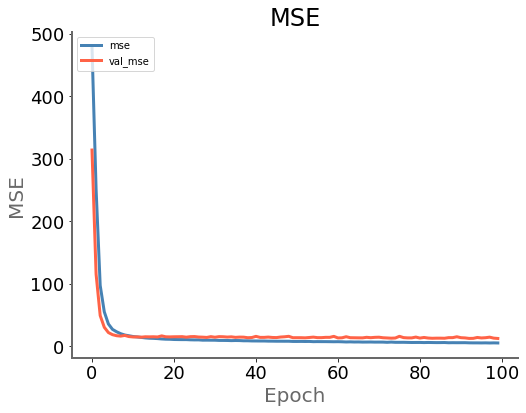

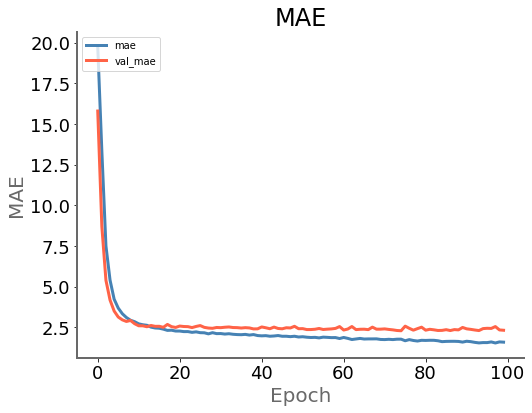

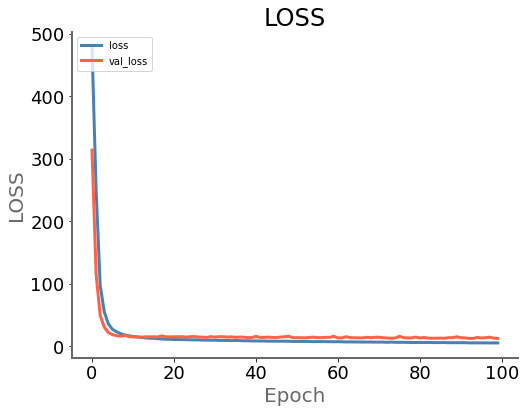

In [12]:
pwk.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
                                'MAE' :['mae', 'val_mae'],
                                'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [13]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2 - Evaluate it :

In [14]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 12.0747
x_test / mae       : 2.3187
x_test / mse       : 12.0747


### 7.3 - Make a prediction

In [15]:
my_data = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
       -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
        0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_data=np.array(my_data).reshape(1,13)

In [16]:
predictions = loaded_model.predict( my_data )
print("Prediction : {:.2f} K$   Reality : {:.2f} K$".format(predictions[0][0], real_price))

Prediction : 11.47 K$   Reality : 10.40 K$


In [17]:
pwk.end()

End time is : Thursday 14 January 2021, 08:11:40
Duration is : 00:00:09 336ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>